In [1]:
import load_data
import preprocess_spectra
import pandas
from importlib import reload
import matplotlib.pyplot as plt
import numpy
import specplotlib
from gekko import GEKKO

#%matplotlib inline

In [2]:
X_SG = numpy.load('X_SG.npy')
X_SG=X_SG[:,:-150] # taking out the Halpha emission sky line
SN_df_w_salt = pandas.read_csv('SN_df_w_salt.csv')
nof_objects = X_SG.shape[0]
nof_objects

cw=numpy.load('CW.npy')
cw=cw[:-150]

# Clean Noise

In [3]:
import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt

def sine_generator(fs, sinefreq, duration):
    T = duration
    nsamples = fs * T
    w = 2. * np.pi * sinefreq
    t_sine = np.linspace(0, T, nsamples, endpoint=False)
    y_sine = np.sin(w * t_sine)
    result = pd.DataFrame({ 
        'data' : y_sine} ,index=t_sine)
    return result

def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

def remove_noise(spec,cutoff,fps=30,order=5,print_flag=True):
    
    fixed = butter_highpass_filter(spec,cutoff,fps,order)
    no_noise=spec-fixed

    if print_flag:
        fig = plt.figure(figsize = (20,25))
        fig.subplots_adjust(hspace=0.1, wspace=0.1)

        plt.subplot(421)
        plt.plot(cw,spec)
        plt.title('check')
        
        plt.subplot(422)
        plt.plot(cw,spec)
        plt.plot(cw,no_noise)
        plt.title('check')
        
        plt.subplot(423)
        plt.plot(cw,fixed)
        plt.title('noise')
        
        plt.subplot(424)
        plt.plot(cw,no_noise)
        plt.title('no_noise')
        plt.show()
        
    return no_noise

# Cubic Spline - Method 1: Finding the points by median in window
## Problem - the cs points are not max

In [4]:
# How do we find point for fit cubic spline??????????????????

def fit_cs(no_noise, n_split, prec, sn, print_flag=True):
    nof_features=len(no_noise)
    cut=nof_features-(nof_features%n_split)
    spec_split=numpy.split(no_noise[:cut],n_split)
    cw_split=numpy.split(cw[:cut],n_split)

    cw_dots=numpy.zeros(n_split)
    spec_dots=numpy.zeros(n_split)

    for i,(c,s) in enumerate(zip(cw_split,spec_split)):
        cw_dots[i]=numpy.median(c)
        spec_dots[i]=numpy.percentile(s,q=prec) #taking the median according to the precentile (not 50% but prec%)

    m = GEKKO()
    m.x = m.Param(value=cw)
    m.y = m.Var()
    m.cspline(m.x,m.y,cw_dots,spec_dots)
    m.options.IMODE=2
    m.solve(disp=False)
    
    norm = no_noise/(m.y)

    if print_flag:
        fig = plt.figure(figsize = (20,7))
        fig.subplots_adjust(hspace=0.1, wspace=0.1)

        plt.subplot(121)
        plt.plot(cw,no_noise)
        plt.scatter(cw_dots,spec_dots,color='green',s=50, label=str(n_split)+', '+sn)
        plt.plot(cw,m.y,'r--',label='cs')
        plt.legend()
        plt.title('dots_and_cubic')

        plt.subplot(122)
        plt.plot(cw,norm)
        #plt.plot(cw[200:],norm[200:])
        plt.title('normalized')
        plt.show()
    
    return norm


# 1994D

In [319]:
numpy.where(SN_df_w_salt['#SN'] == '1994D')

(array([0]),)

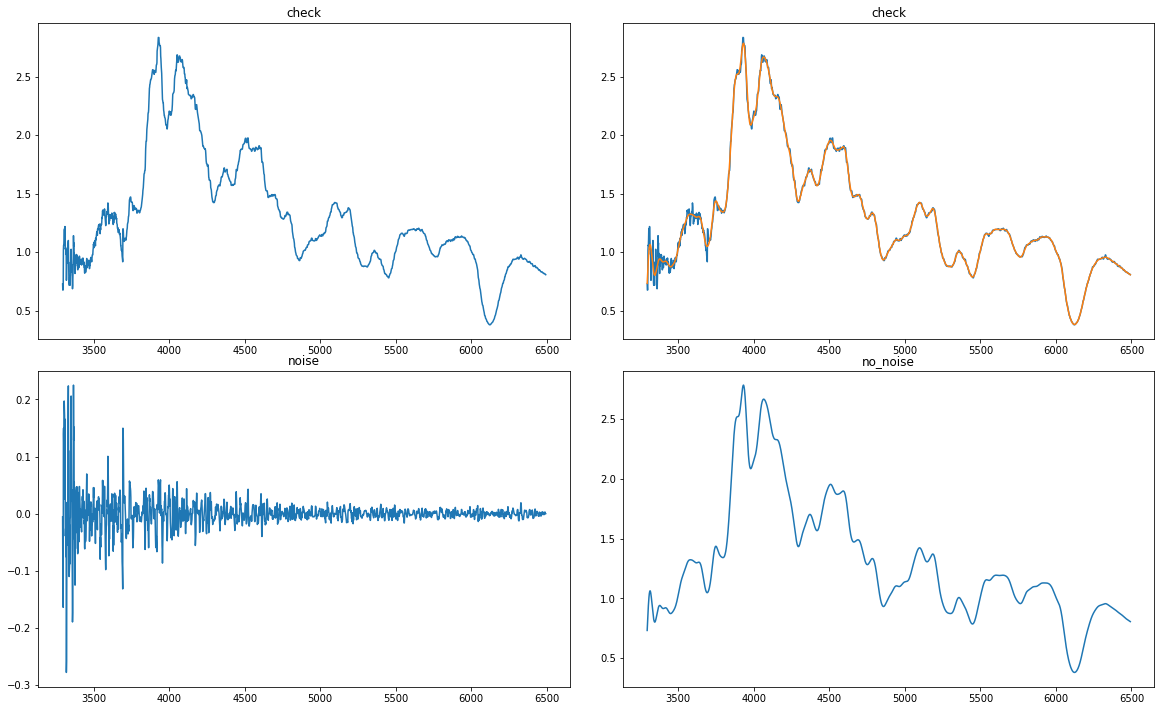

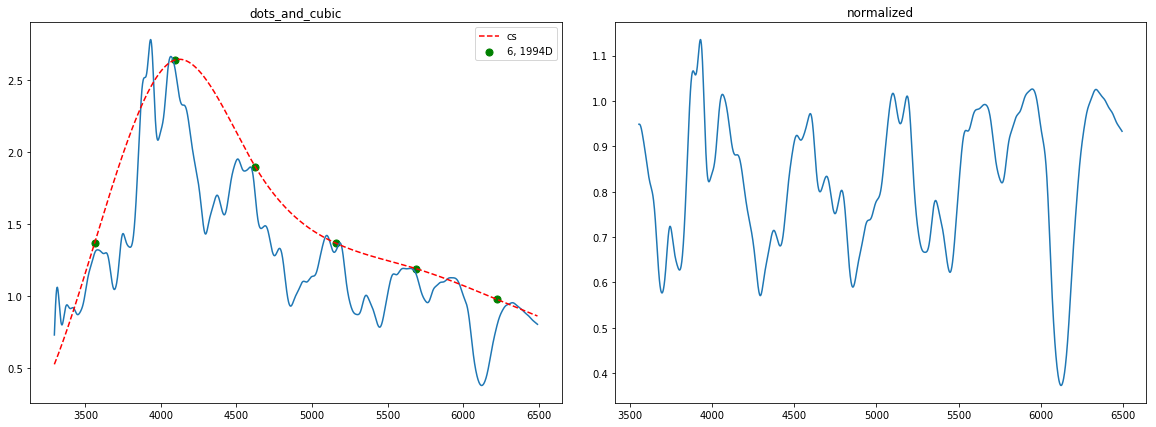

In [339]:
#fps = 30 #how many samples in 1 period ----> leave fixed since degenrate with cutoff
cutoff = 0.8
#order = 5 # --> leave fixed, degenrate with cutoff, how fast the filter declines: https://stackoverflow.com/questions/21862777/bandpass-butterworth-filter-frequencies-in-scipy
indx=0
spec = X_SG[indx]

no_noise=remove_noise(spec,cutoff)

n_split=6 # how many windows/points
prec=90
sn=SN_df_w_salt['#SN'][indx]

norm=fit_cs(no_noise, n_split, prec, sn)

# 2005cc

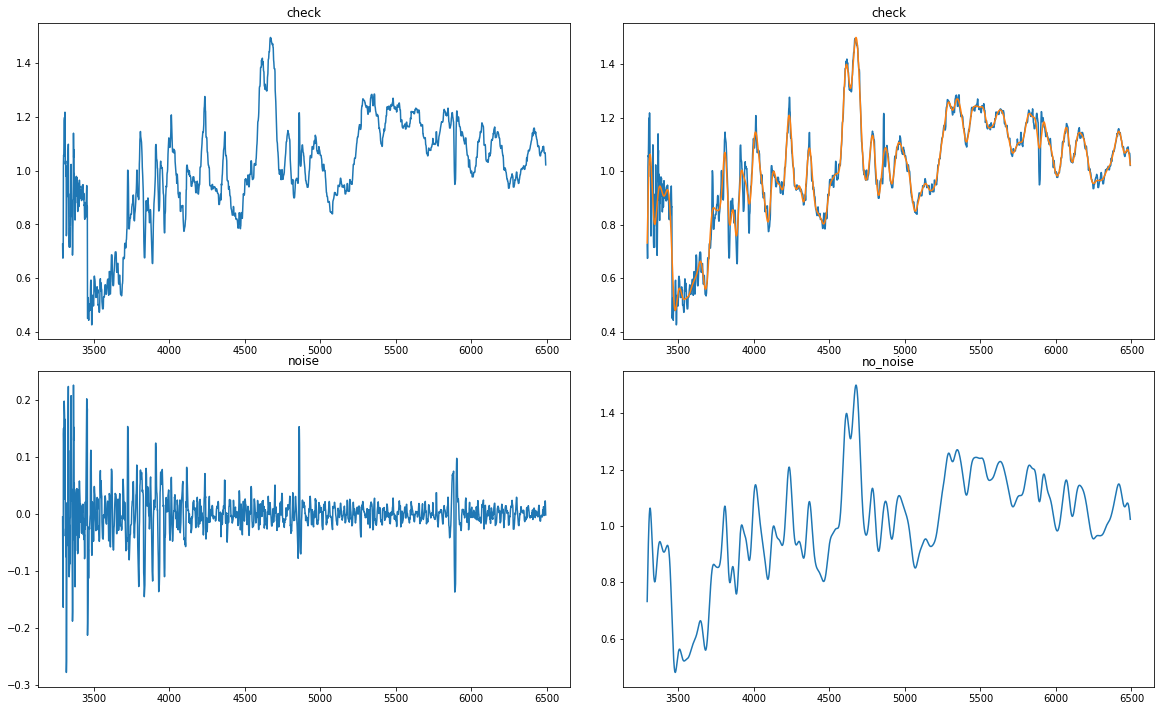

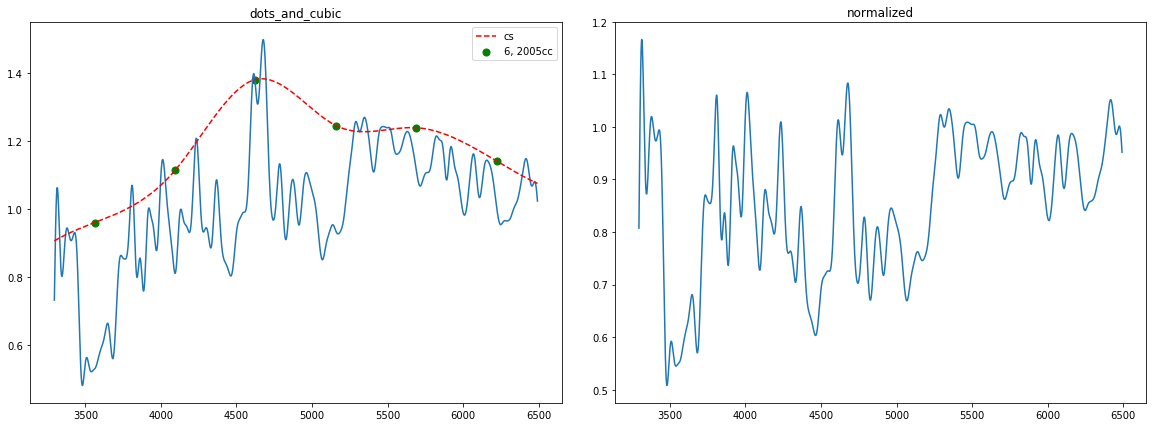

In [347]:
#fps = 30 #how many samples in 1 period ----> leave fixed since degenrate with cutoff
cutoff = 0.8 #less sensitivity to noise --> smaller cutoff
#order = 5 # --> leave fixed, degenrate with cutoff, how fast the filter declines: https://stackoverflow.com/questions/21862777/bandpass-butterworth-filter-frequencies-in-scipy
indx=142
spec = X_SG[indx]

no_noise=remove_noise(spec,cutoff)

n_split=6
prec=90
sn=SN_df_w_salt['#SN'][indx]

norm=fit_cs(no_noise, n_split, prec, sn)

# 1996C

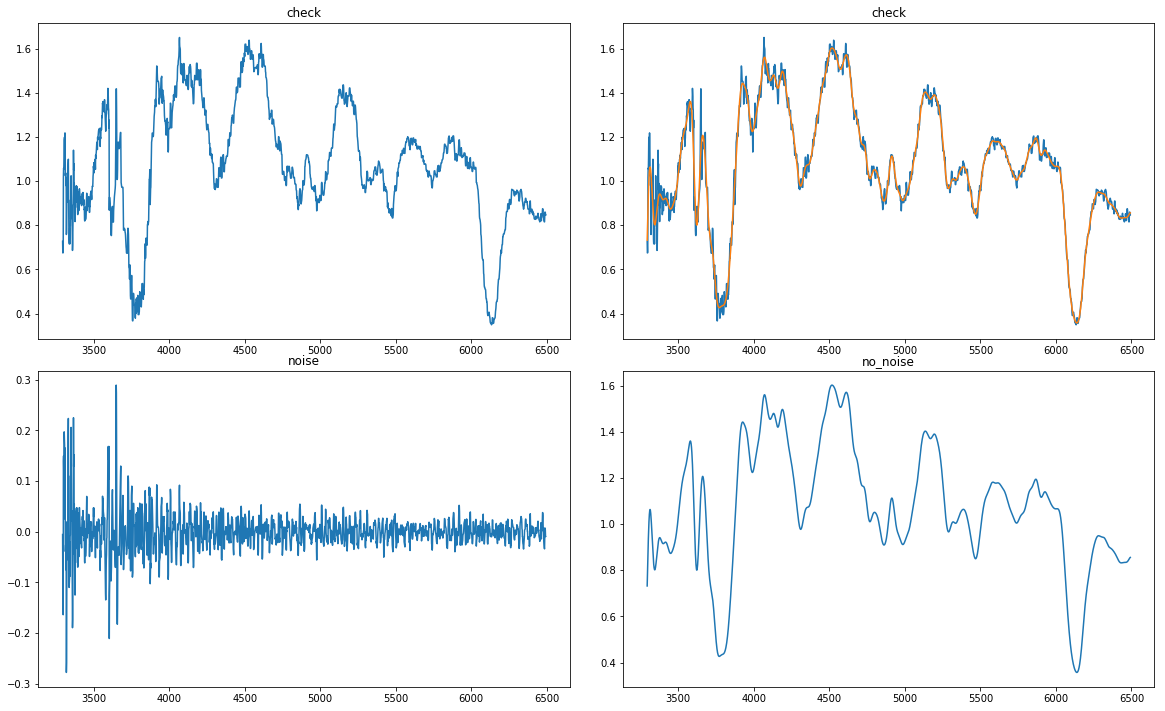

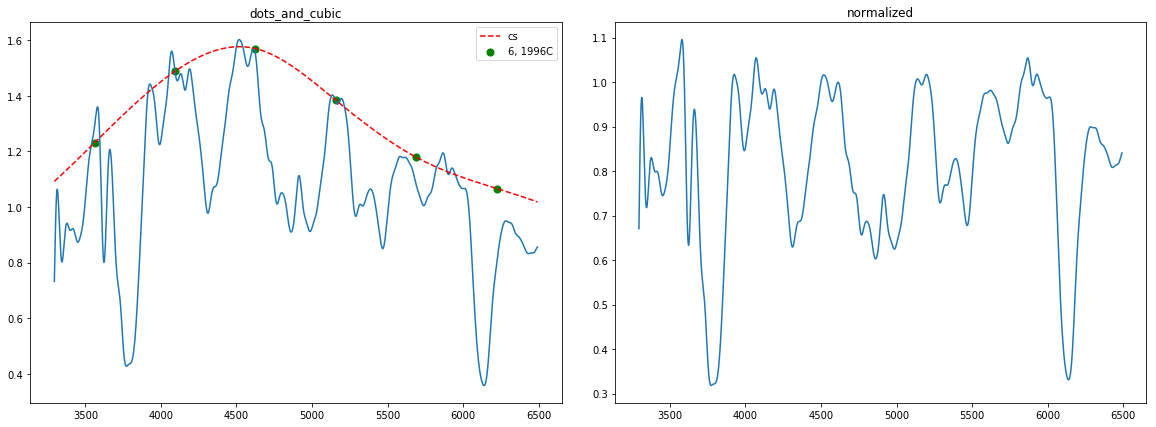

In [411]:
#fps = 30 #how many samples in 1 period ----> leave fixed since degenrate with cutoff
cutoff = 0.8 #less sensitivity to noise --> smaller cutoff
#order = 5 # --> leave fixed, degenrate with cutoff, how fast the filter declines: https://stackoverflow.com/questions/21862777/bandpass-butterworth-filter-frequencies-in-scipy
indx=9
spec = X_SG[indx]

no_noise=remove_noise(spec,cutoff)

n_split=6
prec=90
sn=SN_df_w_salt['#SN'][indx]

norm=fit_cs(no_noise, n_split, prec, sn)

# All SNe Loop

### 1995ac - weird noise - check spectrometer
### 1996Z - bad point in cs
### 1996ab - bad noise in low frequency
### 1996al - bad
### 1996bk - wavy cs points
### 1996bo - wavy cs points
### 1997Y - weird drop at ~3700 - happens in more - check the spectograph or cfa release
### 1999cl - weird drop at ~4400
### 2002cx - needs 1 point in low wavelength
### 2002de - weird drop at ~3700 - happens in more - check the spectograph or cfa release
### 2002es - wavy cs points
### 2003cg - weird drop at ~3700 - happens in more - check the spectograph or cfa release
### 2004fz - weird drop at ~3400 - happens in more - check the spectograph or cfa releas
### 2005eq - needs 1 point in low wavelength
### 2005eu - weird drop at ~3400 - happens in more - check the spectograph or cfa releas
### 2005hk - needs 1 point in low wavelength
### 2006h - weird drop at ~3400 - happens in more - check the spectograph or cfa releas
### 2006x - weird drop at ~3400 - happens in more - check the spectograph or cfa releas
### 2006br - wavy, weird drop at ~3400 - happens in more - check the spectograph or cfa releas
### 2002bw - wavy cs points
### 2006cm - weird drop at ~3400 - happens in more - check the spectograph or cfa releas
### 2006bz - missing cs point in low wl
### 2006cm - wavy
### 2006kf - wavy
### 2007S - wavy
### 2007ae - wavy
### 2007al - wavy
### 2007ux - wavy


In [5]:
#loop running on all SNe to get no noise spectra only

no_noise = []

for indx in range (0,X_SG.shape[0]):
    try:
        #fps = 30 #how many samples in 1 period ----> leave fixed since degenrate with cutoff
        cutoff = 0.8 #less sensitivity to noise --> smaller cutoff
        #order = 5 # --> leave fixed, degenrate with cutoff, how fast the filter declines: https://stackoverflow.com/questions/21862777/bandpass-butterworth-filter-frequencies-in-scipy
        spec = X_SG[indx]

        no_noise += [remove_noise(spec, cutoff, print_flag=False)]
        print(indx)

    except:
        no_noise += [None]
        print(str(indx)+'bad')


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228


In [11]:
noise_clean = numpy.vstack(no_noise)

In [13]:
numpy.save('no_noise_spec', noise_clean)

In [14]:
ls

CW.npy                       lc_fit_cfa2.ipynb
Cubic_Spline.ipynb           load_data.py
Data_draft.ipynb             no_noise_spec.npy
README.md                    norm_spec/
SN_df_w_salt.csv             preprocess_spectra.py
SN_ra_dec.csv                sn_spec_time.npy
X_SG.npy                     specplotlib.py
__pycache__/                 trash/
data/                        umap_0.npy
data_exploration.ipynb       umap_explore.ipynb
data_exploration.ipynb.orig  umap_good.npy
lc_fit.ipynb


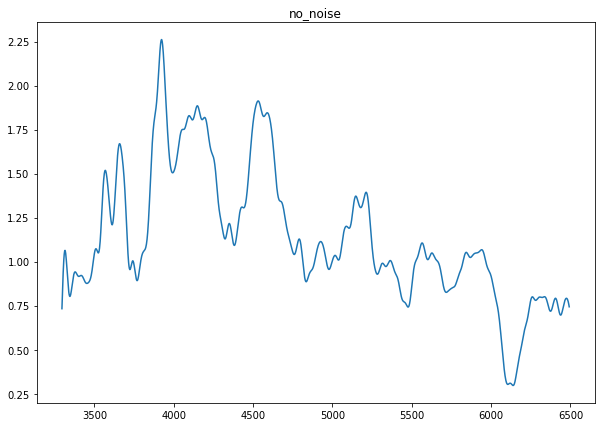

In [10]:
plt.figure(figsize = (10,7))
plt.plot(cw,no_noise[33])
plt.title('no_noise')
plt.show()

In [ ]:
#loop running on all SNe with no noise for only norm

norm = []

for indx in range (0,X_SG.shape[0]):
    try:
        n_split=6
        prec=95
        sn=SN_df_w_salt['#SN'][indx]

        norm += [fit_cs(no_noise[indx], n_split, prec, sn, print_flag=False)]
        print(indx)
    except:
        norm += [None]
        print(indx)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


In [ ]:
#loop running on all SNe for noise+norm

no_noise = []
norm = []

for indx in range (0,X_SG.shape[0]):
    try:
        #fps = 30 #how many samples in 1 period ----> leave fixed since degenrate with cutoff
        cutoff = 0.8 #less sensitivity to noise --> smaller cutoff
        #order = 5 # --> leave fixed, degenrate with cutoff, how fast the filter declines: https://stackoverflow.com/questions/21862777/bandpass-butterworth-filter-frequencies-in-scipy
        spec = X_SG[indx]

        no_noise += [remove_noise(spec, cutoff, print_flag=False)]

        n_split=6
        prec=95
        sn=SN_df_w_salt['#SN'][indx]

        norm += [fit_cs(no_noise[indx], n_split, prec, sn, print_flag=False)]
        print(indx)
    except:
        no_noise += [None]
        norm += [None]
        print(indx)


0
1
2
3
4
5
6


In [7]:
# loop for all Nones

for indx in range (0,X_SG.shape[0]):
    if norm[indx] == None:
        try:
            #fps = 30 #how many samples in 1 period ----> leave fixed since degenrate with cutoff
            cutoff = 0.8 #less sensitivity to noise --> smaller cutoff
            #order = 5 # --> leave fixed, degenrate with cutoff, how fast the filter declines: https://stackoverflow.com/questions/21862777/bandpass-butterworth-filter-frequencies-in-scipy
            spec = X_SG[indx]

            no_noise[indx] = [remove_noise(spec, cutoff, print_flag=False)]

            n_split=6
            prec=95
            sn=SN_df_w_salt['#SN'][indx]

            norm[indx] = [fit_cs(no_noise[indx], n_split, prec, sn, print_flag=False)]
        except:
            no_noise[indx] = [None]
            norm[indx] = [None]
            print(indx)


229

# Cubic Spline - Second Method: find fitting points by max value in choosen window
## Problems: the tale of the fit + sensitive to window -------> NOT CHOOSEN!!

In [305]:
# find point for fit cubic spline according to max value in choosen window

def fit_max_to_cs(no_noise, window, sn, print_flag=True):

    maxes = []
    vec = no_noise.copy()
    nof_features = len(vec)

    for i in range(0,(nof_features), window):
        maxes += [i + numpy.argmax(vec[i:i+window])]
    maxes = numpy.unique(maxes)
    len(maxes)
    
    from gekko import GEKKO
    m = GEKKO()
    m.x = m.Param(value=cw)
    m.y = m.Var()
    m.cspline(m.x,m.y,cw[maxes],no_noise[maxes])
    m.options.IMODE=2
    m.solve(disp=False)

    norm = no_noise/(m.y)
 
    if print_flag:
        fig = plt.figure(figsize = (20,7))
        fig.subplots_adjust(hspace=0.1, wspace=0.1)
        
        plt.subplot(121)
        plt.plot(cw,no_noise)
        plt.scatter(cw[maxes],no_noise[maxes],color='green',s=50, label=str(len(maxes))+', '+sn)
        plt.plot(cw,m.y,'r--',label='cs')
        plt.legend()
        plt.title('maxes_and_cubic')

        plt.subplot(122)
        plt.plot(cw[200:],norm[200:])
        plt.title('normalized')
        plt.show()
    
    return norm

# 1994D

In [309]:
numpy.where(SN_df_w_salt['#SN'] == '1994D')

(array([0]),)

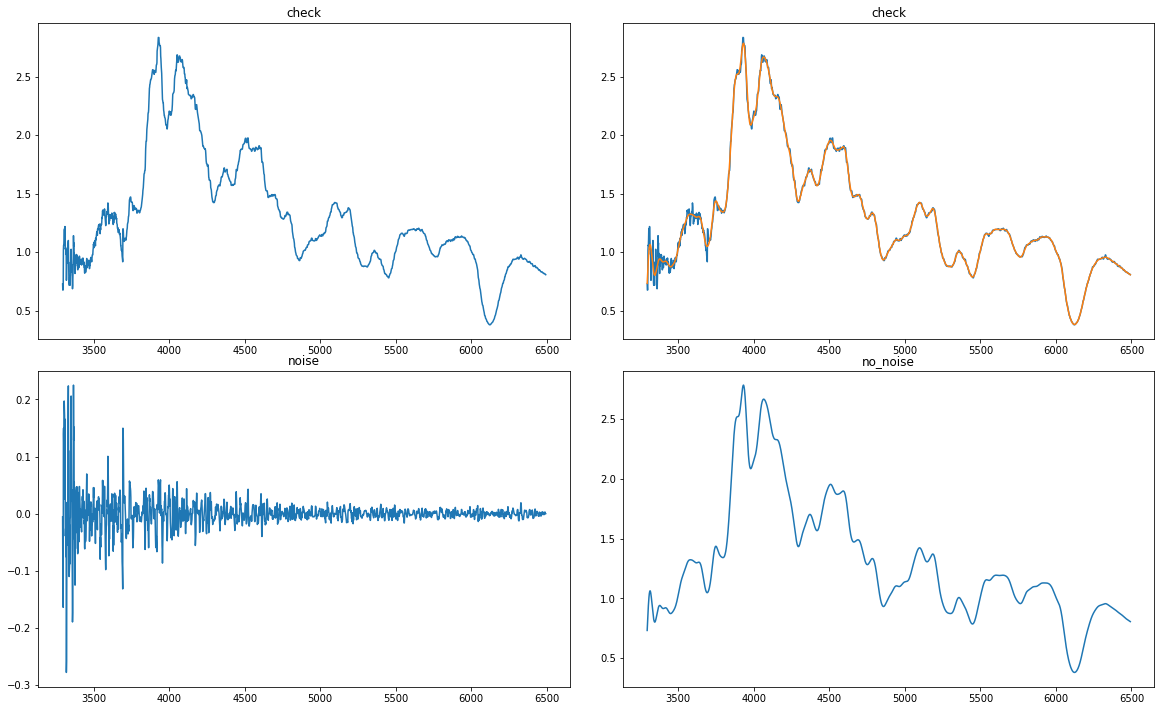

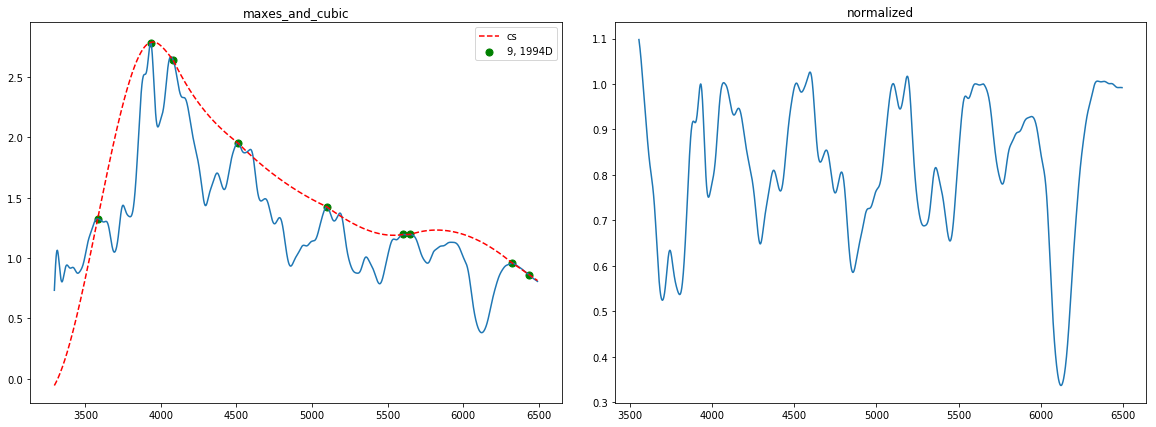

In [341]:
#fps = 30 #how many samples in 1 period ----> leave fixed since degenrate with cutoff
cutoff = 0.8 #less sensitivity to noise --> smaller cutoff
#order = 5 # --> leave fixed, degenrate with cutoff, how fast the filter declines: https://stackoverflow.com/questions/21862777/bandpass-butterworth-filter-frequencies-in-scipy
indx=0
spec = X_SG[indx]

no_noise=remove_noise(spec,cutoff)

window = 300
sn=SN_df_w_salt['#SN'][indx]

norm2=fit_max_to_cs(no_noise, window, sn)

# 2005cc

In [304]:
numpy.where(SN_df_w_salt['#SN'] == '2005cc')

(array([142]),)

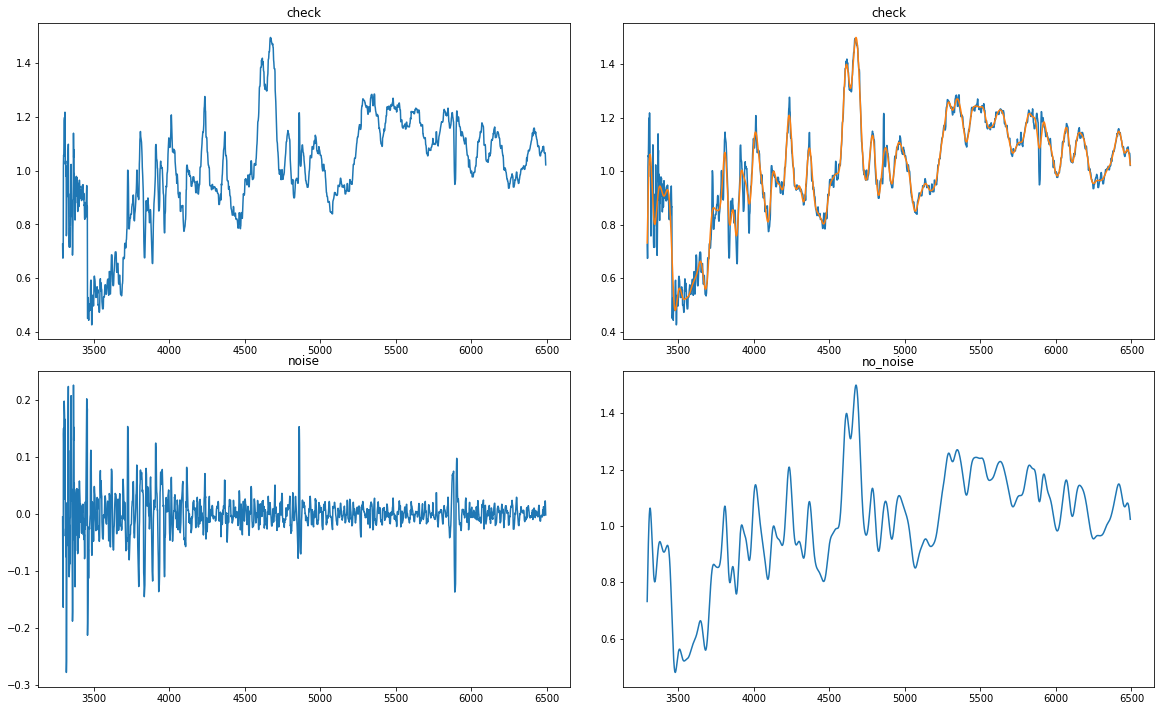

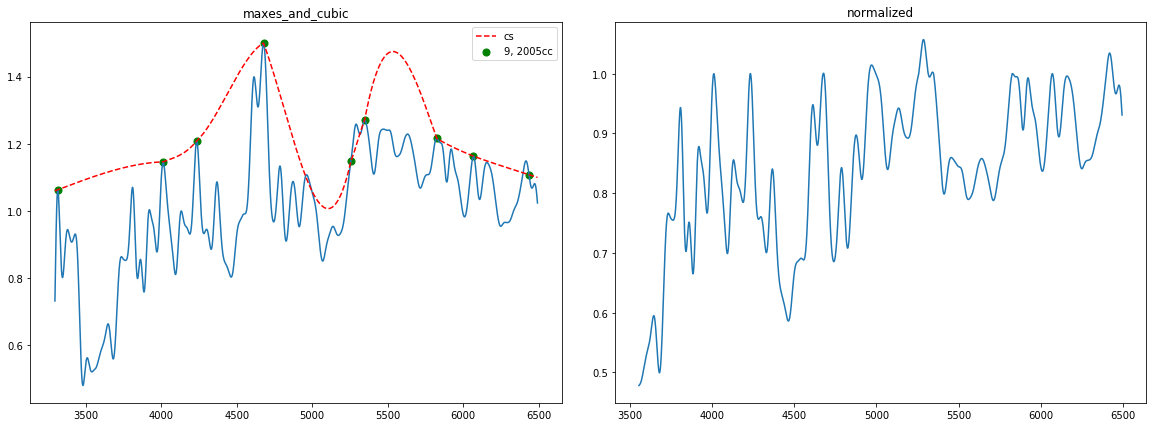

In [342]:
#fps = 30 #how many samples in 1 period ----> leave fixed since degenrate with cutoff
cutoff = 0.8 #less sensitivity to noise --> smaller cutoff
#order = 5 # --> leave fixed, degenrate with cutoff, how fast the filter declines: https://stackoverflow.com/questions/21862777/bandpass-butterworth-filter-frequencies-in-scipy
indx=142
spec = X_SG[indx]

no_noise=remove_noise(spec,cutoff)

window = 300
sn=SN_df_w_salt['#SN'][indx]

norm2=fit_max_to_cs(no_noise, window, sn)

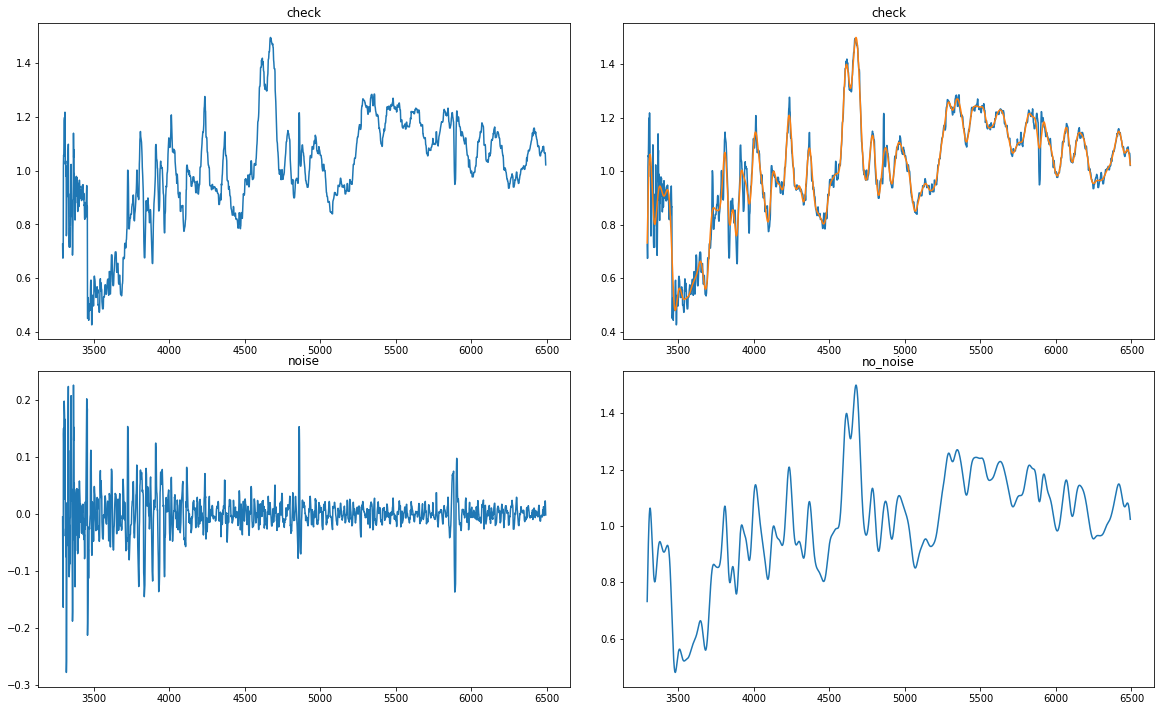

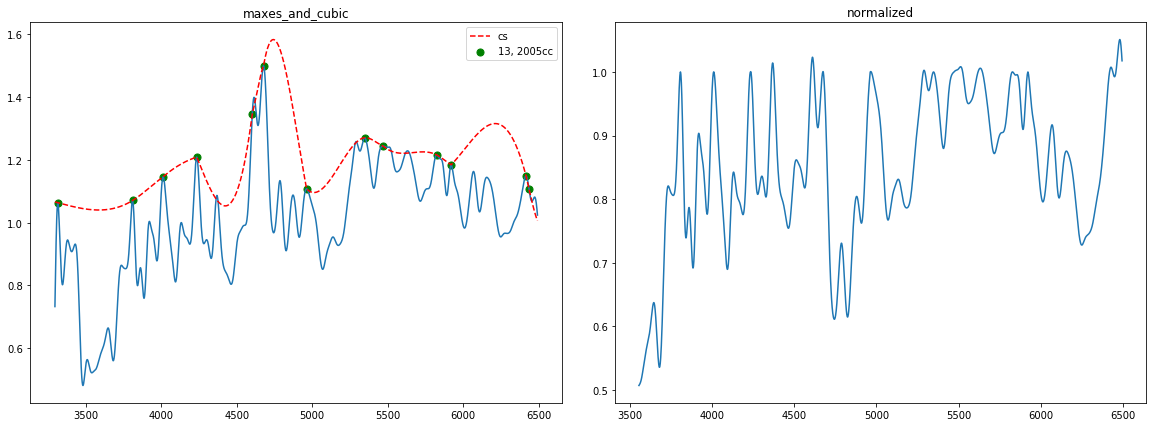

In [343]:
#fps = 30 #how many samples in 1 period ----> leave fixed since degenrate with cutoff
cutoff = 0.8 #less sensitivity to noise --> smaller cutoff
#order = 5 # --> leave fixed, degenrate with cutoff, how fast the filter declines: https://stackoverflow.com/questions/21862777/bandpass-butterworth-filter-frequencies-in-scipy
indx=142
spec = X_SG[indx]

no_noise=remove_noise(spec,cutoff)

window = 200
sn=SN_df_w_salt['#SN'][indx]

norm2=fit_max_to_cs(no_noise, window, sn)

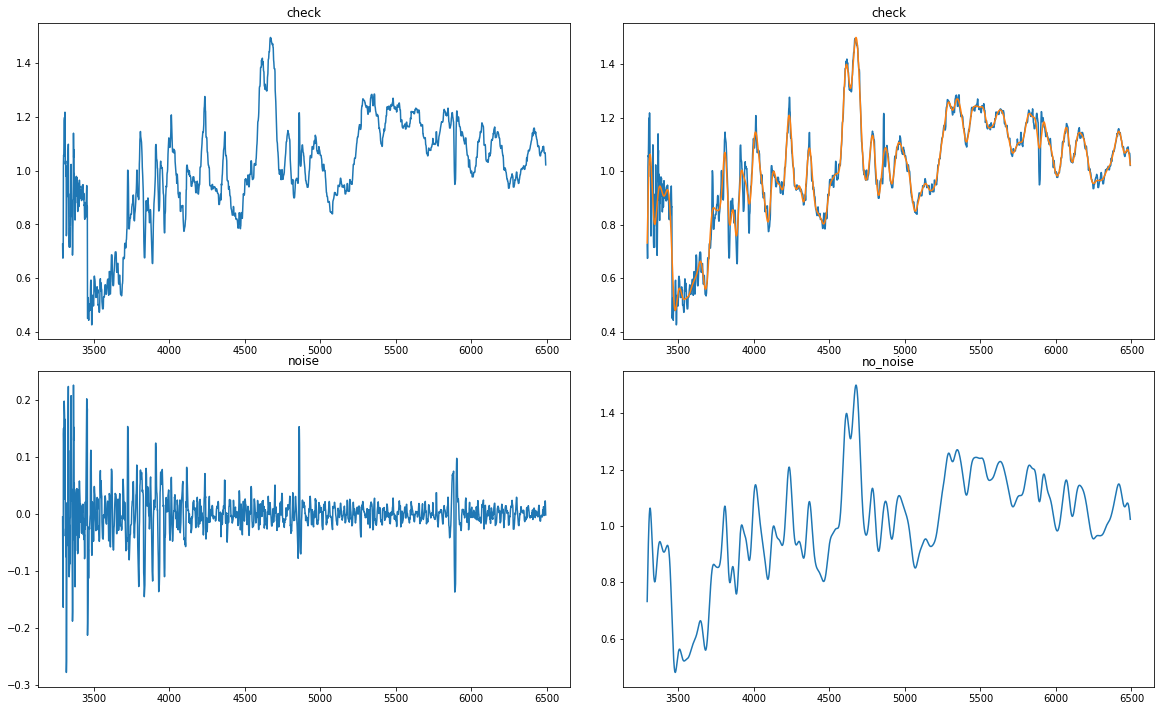

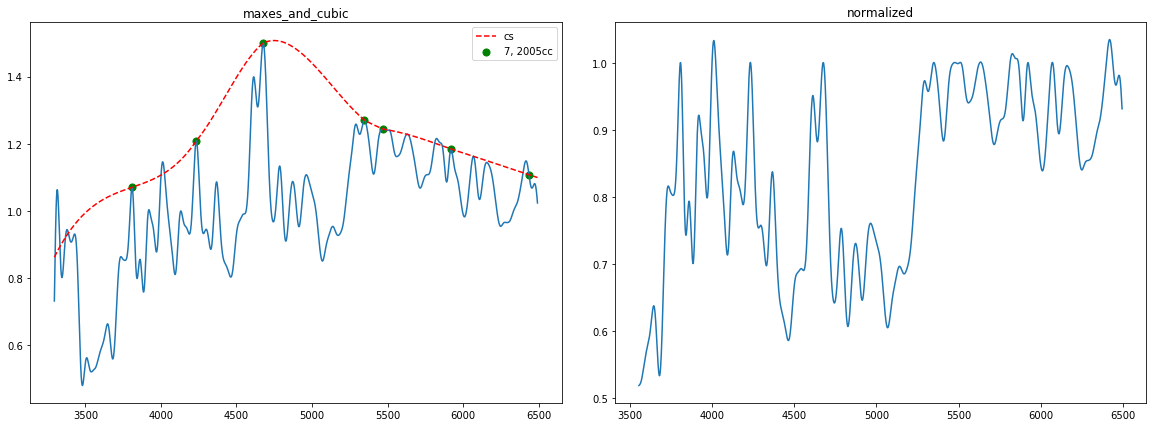

In [344]:
#fps = 30 #how many samples in 1 period ----> leave fixed since degenrate with cutoff
cutoff = 0.8 #less sensitivity to noise --> smaller cutoff
#order = 5 # --> leave fixed, degenrate with cutoff, how fast the filter declines: https://stackoverflow.com/questions/21862777/bandpass-butterworth-filter-frequencies-in-scipy
indx=142
spec = X_SG[indx]

no_noise=remove_noise(spec,cutoff)

window = 400
sn=SN_df_w_salt['#SN'][indx]

norm2=fit_max_to_cs(no_noise, window, sn)